In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.0.0


1. This model is inspired by the article on Medium: 
https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
2. The task is treated as a document classification task where the input is the entity pair and sorrounding context, the label to be predicted is the relation type
3. Example: 
- entity1: information retrieval techniques,
- entity2: keywords, 
- label=USAGE 
- entity1 with context: traditional information retrieval techniques use a
- entity2 with context: histogram of keywords as the 
- input: traditional information retrieval techniques use a histogram of keywords as the 
- label: USAGE

In [2]:
import pickle
import pandas as pd
import numpy as np
#import the pickeled file prepared for training the model. 
#it consists of the pair of entities with the sorrounding context of both entities and the label for each pair. 
train = pd.read_pickle("train.pkl")
print(train)

                                            entity_pair          label
0     database traditional information retrieval tec...          USAGE
1     representation but oral communication may offe...          USAGE
2     a large database of tv database of tv shows em...     PART_WHOLE
3     of a distributed message-passing infrastructur...  MODEL-FEATURE
4     laboratory) the cclinc korean-to-english trans...     PART_WHOLE
...                                                 ...            ...
1223  whether its sentences are used the same contex...  MODEL-FEATURE
1224  bound of accuracy of 77% using only topic info...         RESULT
1225  proposed, allowing non-terminals to consist se...     PART_WHOLE
1226  strongly adequate grammar for crossed grammar ...          USAGE
1227  an existing parsing method for gpsg method for...          USAGE

[1228 rows x 2 columns]


In [3]:
#display the entity types. 
from collections import Counter
distinct_list= (Counter(train['label']).keys())
print(distinct_list)

dict_keys(['USAGE', 'PART_WHOLE', 'MODEL-FEATURE', 'RESULT', 'COMPARE', 'TOPIC'])


We will map the entity types to numerical value because some of entity types like PART_WHOLE and MODEL-FEATURE consists of two tokens. This couses a problem because the model expects a 1-Dimensional vector for the label but if we have two tokens for some labels the representation for these will be a matrix with 2 dimensions. 

In [4]:
Label = {'USAGE': 0, 'PART_WHOLE': 1, 'MODEL-FEATURE': 2, 'RESULT': 3, 'COMPARE': 4, 'TOPIC': 5}

In [5]:
labels_df = pd.DataFrame(Label.items(), columns=['label', 'label_nr'])
print(labels_df)

           label  label_nr
0          USAGE         0
1     PART_WHOLE         1
2  MODEL-FEATURE         2
3         RESULT         3
4        COMPARE         4
5          TOPIC         5


In [6]:
map_labels = pd.merge(train, labels_df, on='label')

We add another column with labels in numerical form to the dataframe, and use only values of 'lable_nr' column for training. 

In [7]:
print(map_labels[1220:])

                                            entity_pair  label  label_nr
1220  presents a critical discussion of the in the e...  TOPIC         5
1221  semantic theories of natural theories of natur...  TOPIC         5
1222  of the proportion problem and given from a gen...  TOPIC         5
1223  evolved in speech and text image processing wo...  TOPIC         5
1224  of the cross-lingual comparisons provided by b...  TOPIC         5
1225  take existing computational semantic analyses ...  TOPIC         5
1226  no particular user interface styles or convent...  TOPIC         5
1227  of the definitions are produced relatively rob...  TOPIC         5


1. Vocabulary size is the size of the vocabulary that we created in previous steps.
2. Choose and embedding dimension of 64.
3. According to some statistical analysis we made with the dataset, the maximum lenght of sequences is:  27 and the minimum 7. while the average sequence lngth is 12.46 and the median is 12. So we decided to have a maximum length of the sequence equal to 12. 
4. Do padding for sequences smaller than 12 and trucating for sequences larger than 12. 
5. oov_token stands for tokens which are not found in the vocabulary. 
6. Decide 80% of the data for training and 20% validation. 

In [8]:
vocab_size = 4297
embedding_dim = 64
max_length = 12
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [9]:
#create two lists for holding entity pair and labels.
entities = []
labels = []

In [10]:
for row in map_labels['entity_pair']:
    entities.append(row)
    
for label in map_labels['label_nr']:
    labels.append(label)

In [11]:
#we get 982 samples for training and 246 sample for validation
train_size = int(len(entities) * training_portion)

train_entities = entities[0: train_size]
train_labels = labels[0: train_size]

validation_entities = entities[train_size:]
validation_labels = labels[train_size:]

In [12]:
#Here we show the index of the tokens present in the training data after tokenization.
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_entities)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:15])

{'<OOV>': 1,
 'the': 2,
 'of': 3,
 'a': 4,
 'in': 5,
 'for': 6,
 'and': 7,
 'to': 8,
 'on': 9,
 'based': 10,
 'from': 11,
 'is': 12,
 'with': 13,
 'that': 14,
 'an': 15}

In this part we make some statistical calculations that will help us decide for the maximum sequence length. 

In [13]:
len_seq = []
train_sequences = tokenizer.texts_to_sequences(train_entities)
for i in range (len(train_sequences)):
    len_seq.append(len(train_sequences[i]))

def Average(lst): 
    return sum(lst) / len(lst) 

In [14]:
import statistics 
print('The maximum sequence length is: ', max(len_seq))
print('The minimum sequence length is: ', min(len_seq))
print('The average length of the squence is: ', Average(len_seq)) 
print('The median length of the squence is: ', statistics.median(len_seq)) 

The maximum sequence length is:  27
The minimum sequence length is:  7
The average length of the squence is:  12.466395112016293
The median length of the squence is:  12.0


In [15]:
#Some examples after padding the sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(train_padded.shape)
type(train_padded)

12
12
11
12
(982, 12)


numpy.ndarray

In [16]:
#an example of the training data expresed with word indices. 
print(train_padded[1])

[  90  297 1207  357  358  775  775  298 1208   69   20    0]


In [17]:
#246 samples for validation with sequence length 12
validation_sequences = tokenizer.texts_to_sequences(validation_entities)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

246
(246, 12)


In [20]:
train_labels = pd.array(train_labels)
train_labels = train_labels.to_numpy()
print(train_labels[:20])
validation_labels = pd.array(validation_labels)
validation_labels = validation_labels.to_numpy()
print(validation_labels[200:246])
type(train_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5]


numpy.ndarray

In [38]:
train_labels.shape

(982,)

In [21]:
model = tf.keras.Sequential([
    # Add an Embedding layer, input is the vocab of size , and output embedding dimension decided at the begining. 
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    #Choose a bidirectional LSTM layer to better capture the context.  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # use ReLU as an activation function
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          275008    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 349,702
Trainable params: 349,702
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Train on 982 samples, validate on 246 samples
Epoch 1/100
982/982 - 9s - loss: 1.5173 - accuracy: 0.4664 - val_loss: 4.3989 - val_accuracy: 0.0000e+00
Epoch 2/100
982/982 - 1s - loss: 0.9468 - accuracy: 0.5611 - val_loss: 6.2079 - val_accuracy: 0.0488
Epoch 3/100
982/982 - 1s - loss: 0.6003 - accuracy: 0.7597 - val_loss: 9.7062 - val_accuracy: 0.1667
Epoch 4/100
982/982 - 1s - loss: 0.2903 - accuracy: 0.8971 - val_loss: 9.2282 - val_accuracy: 0.1220
Epoch 5/100
982/982 - 1s - loss: 0.1213 - accuracy: 0.9633 - val_loss: 11.1465 - val_accuracy: 0.1260
Epoch 6/100
982/982 - 1s - loss: 0.0453 - accuracy: 0.9878 - val_loss: 11.4549 - val_accuracy: 0.1463
Epoch 7/100
982/982 - 1s - loss: 0.0206 - accuracy: 0.9949 - val_loss: 11.9774 - val_accuracy: 0.1504
Epoch 8/100
982/982 - 1s - loss: 0.0103 - accuracy: 0.9980 - val_loss: 12.8256 - val_accuracy: 0.1260
Epoch 9/100
982/982 - 1s - loss: 0.0065 - accuracy: 0.9990 - val_loss: 11.7279 - val_accuracy: 0.1341
Epoch 10/100
982/982 - 1s - loss: 0.

Epoch 78/100
982/982 - 1s - loss: 1.2815e-05 - accuracy: 1.0000 - val_loss: 15.4855 - val_accuracy: 0.1260
Epoch 79/100
982/982 - 1s - loss: 1.2448e-05 - accuracy: 1.0000 - val_loss: 15.5037 - val_accuracy: 0.1260
Epoch 80/100
982/982 - 1s - loss: 1.2079e-05 - accuracy: 1.0000 - val_loss: 15.5201 - val_accuracy: 0.1260
Epoch 81/100
982/982 - 1s - loss: 1.1732e-05 - accuracy: 1.0000 - val_loss: 15.5366 - val_accuracy: 0.1260
Epoch 82/100
982/982 - 1s - loss: 1.1395e-05 - accuracy: 1.0000 - val_loss: 15.5523 - val_accuracy: 0.1260
Epoch 83/100
982/982 - 1s - loss: 1.1071e-05 - accuracy: 1.0000 - val_loss: 15.5714 - val_accuracy: 0.1260
Epoch 84/100
982/982 - 1s - loss: 1.0760e-05 - accuracy: 1.0000 - val_loss: 15.5885 - val_accuracy: 0.1260
Epoch 85/100
982/982 - 1s - loss: 1.0458e-05 - accuracy: 1.0000 - val_loss: 15.6056 - val_accuracy: 0.1260
Epoch 86/100
982/982 - 1s - loss: 1.0169e-05 - accuracy: 1.0000 - val_loss: 15.6215 - val_accuracy: 0.1260
Epoch 87/100
982/982 - 1s - loss: 9.8

We trained the model for 100 epoch but only 10 would have been enough. 
As we can see after the 16th epoch there is no change in validation accuracy. 
Then plot the graphs of accuracy and loss. 

In [24]:
import matplotlib.pyplot as plt

In [25]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

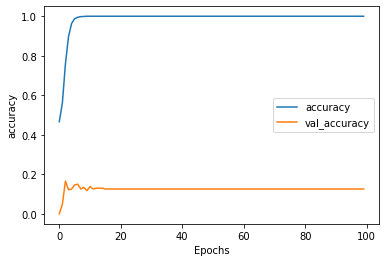

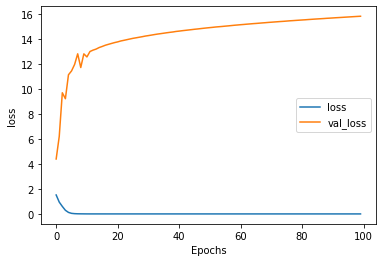

In [26]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")